In [1]:
import matplotlib.pyplot as plt
import Analyzer

In [2]:
mk = Analyzer.MarketDB()
df = mk.get_daily_price('NAVER', '2019-01-02')

end_date is initialized to '2020-10-05'


#### 1. 추세 추종 매매기법
상승 추세에 매수하고 하락 추세에 매도하는 기법

In [3]:
df['MA20'] = df['close'].rolling(window=20).mean() 
df['stddev'] = df['close'].rolling(window=20).std() 
df['upper'] = df['MA20'] + (df['stddev'] * 2)
df['lower'] = df['MA20'] - (df['stddev'] * 2)
df['PB'] = (df['close'] - df['lower']) / (df['upper'] - df['lower'])

# 중심 가격
df['TP'] = (df['high'] + df['low'] + df['close']) / 3

df['PMF'] = 0
df['NMF'] = 0

In [4]:
for i in range(len(df.close)-1):
    if df.TP.values[i] < df.TP.values[i+1]:
        df.PMF.values[i+1] = df.TP.values[i+1] * df.volume.values[i+1]
        df.NMF.values[i+1] = 0
    else:
        df.NMF.values[i+1] = df.TP.values[i+1] * df.volume.values[i+1]
        df.PMF.values[i+1] = 0
df['MFR'] = (df.PMF.rolling(window=10).sum() /
    df.NMF.rolling(window=10).sum())
df['MFI10'] = 100 - 100 / (1 + df['MFR'])
df = df[19:]

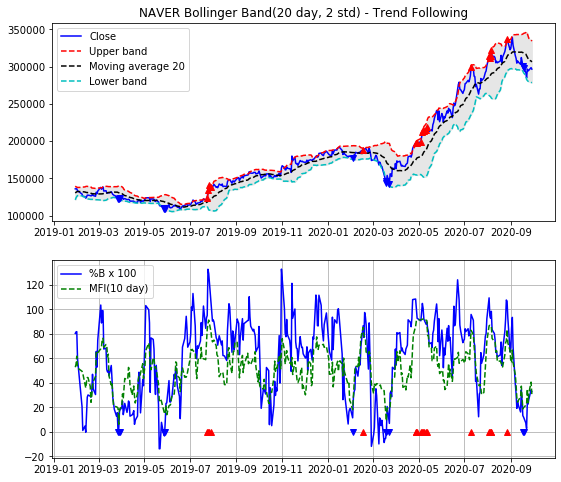

In [5]:
plt.figure(figsize=(9, 8))
plt.subplot(2, 1, 1)
plt.title('NAVER Bollinger Band(20 day, 2 std) - Trend Following')
plt.plot(df.index, df['close'], color='#0000ff', label='Close')
plt.plot(df.index, df['upper'], 'r--', label ='Upper band')
plt.plot(df.index, df['MA20'], 'k--', label='Moving average 20')
plt.plot(df.index, df['lower'], 'c--', label ='Lower band')
plt.fill_between(df.index, df['upper'], df['lower'], color='0.9')
for i in range(len(df.close)):
    if df.PB.values[i] > 0.8 and df.MFI10.values[i] > 80:   
        plt.plot(df.index.values[i], df.close.values[i], 'r^') 
    elif df.PB.values[i] < 0.2 and df.MFI10.values[i] < 20:     
        plt.plot(df.index.values[i], df.close.values[i], 'bv') 
plt.legend(loc='best')

plt.subplot(2, 1, 2)
plt.plot(df.index, df['PB'] * 100, 'b', label='%B x 100')   
plt.plot(df.index, df['MFI10'], 'g--', label='MFI(10 day)') 
plt.yticks([-20, 0, 20, 40, 60, 80, 100, 120]) 
for i in range(len(df.close)):
    if df.PB.values[i] > 0.8 and df.MFI10.values[i] > 80:
        plt.plot(df.index.values[i], 0, 'r^')
    elif df.PB.values[i] < 0.2 and df.MFI10.values[i] < 20:
        plt.plot(df.index.values[i], 0, 'bv')
plt.grid(True)
plt.legend(loc='best')
plt.show()

    MFI가 80을 상회하면 아주 강력한 매수 신호
    MFI가 20을 하회하면 아주 강력한 매도 신호

#### 2. 반전 매매기법
주가가 반전하는 지점을 찾아내 매수 또는 매도하는 기법

---
##### 일중 강도 
일중 강도 = {(2 * 종가 - 고가 - 저가) / (고가 - 저가)} * 거래량

##### 일중 강도율 
일중 강도율 = 일중강도의 21일 합 / 거래량의 21일 합 * 100

In [7]:
df['II'] = (2*df['close']-df['high']-df['low'])/(df['high']-df['low'])*df['volume'] 
df['IIP21'] = df['II'].rolling(window=21).sum()/df['volume'].rolling(window=21).sum()*100 
df = df.dropna()

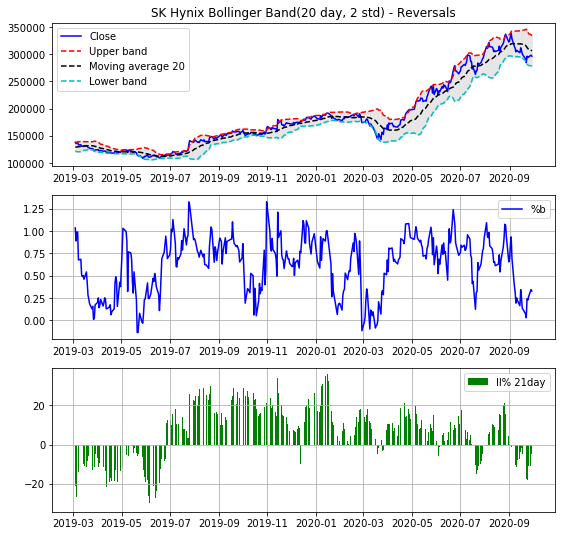

In [8]:
plt.figure(figsize=(9, 9))
plt.subplot(3, 1, 1)
plt.title('SK Hynix Bollinger Band(20 day, 2 std) - Reversals')
plt.plot(df.index, df['close'], 'b', label='Close')
plt.plot(df.index, df['upper'], 'r--', label ='Upper band')
plt.plot(df.index, df['MA20'], 'k--', label='Moving average 20')
plt.plot(df.index, df['lower'], 'c--', label ='Lower band')
plt.fill_between(df.index, df['upper'], df['lower'], color='0.9')

plt.legend(loc='best')
plt.subplot(3, 1, 2)
plt.plot(df.index, df['PB'], 'b', label='%b')
plt.grid(True)
plt.legend(loc='best')

plt.subplot(3, 1, 3)
plt.bar(df.index, df['IIP21'], color='g', label='II% 21day')
plt.grid(True)
plt.legend(loc='best')
plt.show()

    주가가 하단 볼린저 밴드에 닿을 때 일중 강도율이 +이면 매수
    주가가 상단 볼린저 밴드에 닿을 때 일중 강도율이 -이면 매도